In [ ]:
"""
In this notebook, we're going to go through how to use data generator.
# Why using data generator
-- You cannot load everything into the RAM!!!

"""

In [1]:
"""
BLOCK1
Import basic libraries
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re

from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import load_model, save_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Input, BatchNormalization, Activation, Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import Adam
import keras.backend as K

"""
Define shared functions
"""
def op_img(x, im_size):
    # x: image path list (of a batch)
    # im_size:tuple (w,h,c)
    w,h,c = im_size
    X_ = np.array([np.array(Image.open(i).resize((w, h)), dtype='float32') for i in x])
    if c == 1:
        X_ = np.expand_dims(X_, axis = 3)
    else:
        pass
    return X_

Using TensorFlow backend.


In [2]:
"""
BLOCK2
Make datatable
"""
d_train = "dataset/train/"
d_test = "dataset/test1/"
d_aug_out = "dataset/augment/"

img_train_list = glob.glob(d_train + "*.jpg")
img_test_list = glob.glob(d_test + "*.jpg")

### make datatable 
df_train = pd.DataFrame({'img_path': img_train_list})
df_test = pd.DataFrame({'img_path': img_test_list})

# expand df
df_train['cate'] = df_train.img_path.apply(os.path.basename)
df_train['cate'] = [i.split(".")[0] for i in list(df_train.cate)]

df_train.head()

,img_path,cate
0,dataset/train\cat.0.jpg,cat
1,dataset/train\cat.1.jpg,cat
2,dataset/train\cat.10.jpg,cat
3,dataset/train\cat.100.jpg,cat
4,dataset/train\cat.1000.jpg,cat


In [4]:
"""
BLOCK3
Define Image generator parameter
"""
train_datagen = ImageDataGenerator(rotation_range= 30, 
                             width_shift_range= 0.1, 
                             height_shift_range=0.1, 
                             zoom_range=[0.8,1.2], 
                             horizontal_flip= True, 
                             fill_mode= 'nearest')

val_datagen = ImageDataGenerator(rotation_range= 10, 
                             width_shift_range= 0.1, 
                             height_shift_range=0.1, 
                             zoom_range=[0.8,1.2], 
                             #horizontal_flip= True, 
                             fill_mode= 'nearest')
"""
Compare nearest and wrap
# depending on what method will make sense on your data
"""

'\nCompare nearest and wrap\n# depending on what method will make sense on your data\n'

                         img_path cate
16642  dataset/train\dog.2476.jpg  dog
4343   dataset/train\cat.2657.jpg  cat
24493  dataset/train\dog.9542.jpg  dog
20945  dataset/train\dog.6349.jpg  dog
10497  dataset/train\cat.8196.jpg  cat


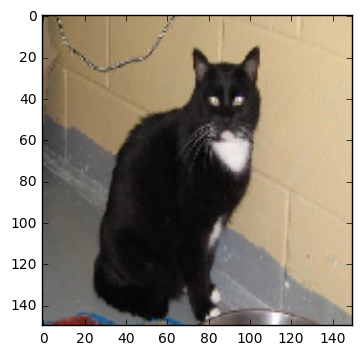

In [5]:
"""
BLOCK3-A
Image generator with save figs
"""


tmp_imgs = df_train.sample(10)
print(tmp_imgs.head())
tmp_imgs = list(tmp_imgs.img_path)
tmp_imgs = op_img(tmp_imgs, (150, 150,3))

plt.imshow(tmp_imgs[1].astype('uint8'))
plt.show()

i = 0
for batch in train_datagen.flow(tmp_imgs, batch_size=10, save_to_dir=d_aug_out, save_format='jpeg'):
    i += 1
    if i > 5:
        break

In [6]:
"""
BLOCK4
Write a class function for generator
"""
class call_generator():
    def __init__(self, params_dict, dta_gen = None):
        self.tags = params_dict['tags']
        self.im_w, self.im_h = params_dict['im_w'], params_dict['im_h']
        self.channels = params_dict['im_c']
        self.data_gen = dta_gen
    #
    
    def train_generator(self, bz, 
                        df_class0, df_class1, 
                        class_0_ratio = 1, class_1_ratio = 1):
        while(1):
            per_get = bz / len(self.tags)
            X_ = []
            Y_ = []
            
            # get balanced input for each mini-batch
            i_get_0 = df_class0.sample(n = int(per_get * class_0_ratio))
            i_get_1 = df_class1.sample(n = int(per_get * class_0_ratio))
            i_get = pd.concat((i_get_0, i_get_1))
            
            X_ = list(i_get.img_path)
            Y_ = list(i_get.cate)
            
            # open image array
            X_ = op_img(X_, (self.im_w, self.im_h, self.channels))
            
            # make y into one-hot-encoding
            le = preprocessing.LabelEncoder()
            le.fit(self.tags)
            Y_ = le.transform(Y_)
            Y_ = np_utils.to_categorical(Y_, len(self.tags))
            
            if self.data_gen is None:
                pass
            else:
                datagen = self.data_gen
                datagen.fit(X_) # if there is no special transform, you can skip this line
                for X_, Y_ in datagen.flow(X_, Y_, batch_size= len(X_)):
                    # only do it once
                    break
            X_ = X_.astype('float32')
            """
            Add your other hand-craft preprocessing function here
            for example, -imagenet mean, -dataset mean ...
            we don't need preproc in this case
            X_ = image_preprocess(X_)
            """
            
            # finally, we yield data
            yield X_, Y_
    
    def get_validation(self, df_class0, df_class1, 
                       class_0_ratio = 1, class_1_ratio = 1, 
                       use_im_gen = None, n_gen_loop = 3):
        X_ = []
        Y_ = []
        per_get = len(df_class1)
        
        i_get_0 = df_class0.sample(n = int(per_get * class_0_ratio) )
        i_get_1 = df_class1
        i_get = pd.concat((i_get_0, i_get_1))
        
        X_ = list(i_get.img_path)
        Y_ = list(i_get.cate)
        print(len(X_))
        
        X_ = op_img(X_, (self.im_w, self.im_h, self.channels))
        le = preprocessing.LabelEncoder()
        le.fit(self.tags)
        Y_ = le.transform(Y_)
        Y_ = np_utils.to_categorical(Y_, len(self.tags))
        
        if use_im_gen is None:
            pass
        else:
            datagen = use_im_gen
            datagen.fit(X_)
            i_start = 1
            i_end = n_gen_loop
            if i_end > 0:
                for X_gen, Y_gen in datagen.flow(X_, Y_, batch_size=len(X_), shuffle=False):
                    X_ = np.concatenate((X_, X_gen))
                    Y_ = np.concatenate((Y_, Y_gen))
                    if i_start == i_end:
                        break
                    i_start += 1
        print(X_.shape)
        X_ = X_.astype('float32')
        """
        Add your other hand-craft preprocessing function here
        for example, -imagenet mean, -dataset mean ...
        we don't need preproc in this case
        """
        return X_, Y_
                

In [7]:
"""
BLOCK5
Data and model parameter init
"""
im_w, im_h, im_c = 120, 120, 3
bz = 24
lr = 0.0001

mini_mode = True

if mini_mode:
    nb_epoch = 10
    nb_updates_per_epoch = 50
else:
    nb_epoch = 100
    nb_updates_per_epoch = 250


generator_params = {'tags': ['cat', 'dog'], 
               'im_w': im_w, 'im_h': im_h, 'im_c': im_c}

gen_data = call_generator(generator_params, dta_gen = train_datagen)

df_train_0, df_val_0 = train_test_split(df_train[df_train['cate'] == 'cat'], test_size = 0.05)
df_train_1, df_val_1 = train_test_split(df_train[df_train['cate'] == 'dog'], test_size = 0.05)

x_val, y_val = gen_data.get_validation(df_class0= df_val_0, df_class1= df_val_1, 
                                       class_0_ratio=1, class_1_ratio=1, use_im_gen = val_datagen, n_gen_loop = 2)

1250
(3750, 120, 120, 3)


In [8]:
"""
BLOCK5-A
Demo of generator output (useful for debugging)
"""
gen_data = call_generator(generator_params, dta_gen = train_datagen)
tmp = gen_data.train_generator(df_class0=df_train_0, df_class1=df_train_1, bz=bz)
a,b = next(tmp)
print(a.shape)
print(b.shape)

(24, 120, 120, 3)
(24, 2)


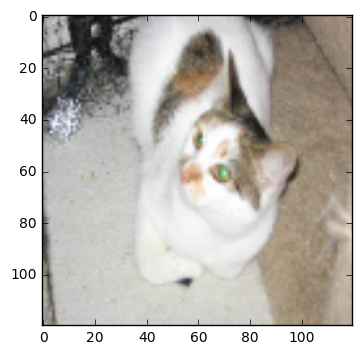

In [12]:
"""
BLOCK5-B
CKECK VALIDATION AUG DATA
"""
plt.imshow(x_val[21,].astype('uint8'))
plt.show()

In [13]:
"""
BLOCK6
Define model
"""
input_img = Input(shape=(im_w, im_h, 3))
x = Conv2D(kernel_size=(3,3), filters=64, padding='same')(input_img)
x = BatchNormalization(axis= -1)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(kernel_size=(3,3), filters=128, padding='same')(x)
x = BatchNormalization(axis= -1)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(kernel_size=(3,3), filters=128, padding='same')(x)
x = BatchNormalization(axis= -1)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(kernel_size=(3,3), filters=512, padding='same')(x)
x = BatchNormalization(axis= -1)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)

x = Dense(128)(x)
x = BatchNormalization(axis= -1)(x)
x = Activation('relu')(x)

x = Dense(2)(x)
out = Activation('softmax')(x)

model = Model(inputs=[input_img], outputs=[out])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 120, 64)      1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 120, 120, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 120, 120, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 60, 128)       512       
__________

In [14]:
"""
BLOCK7
Compile the model
"""
my_optimizer = Adam(lr = lr)
model.compile(loss = 'binary_crossentropy', optimizer= my_optimizer, metrics=['acc'])

In [12]:
"""
BLOCK8
Train the model
"""
history_model = model.fit_generator(gen_data.train_generator(df_class0=df_train_0, 
                                                       df_class1=df_train_1,
                                                       bz=bz), 
                              steps_per_epoch = nb_updates_per_epoch, epochs = nb_epoch, 
                              validation_data = (x_val, y_val)
                             )
if mini_mode:
    pass
else:
    model.save("cat_dog.h5")

Epoch 1/100
250/250 [==============================] - 130s - loss: 0.6342 - acc: 0.6763 - val_loss: 0.5629 - val_acc: 0.7224
Epoch 2/100
250/250 [==============================] - 125s - loss: 0.5448 - acc: 0.7273 - val_loss: 0.6109 - val_acc: 0.6816
Epoch 3/100
250/250 [==============================] - 124s - loss: 0.5108 - acc: 0.7383 - val_loss: 0.5239 - val_acc: 0.7424
Epoch 4/100
250/250 [==============================] - 123s - loss: 0.4976 - acc: 0.7587 - val_loss: 0.4517 - val_acc: 0.7792
Epoch 5/100
250/250 [==============================] - 125s - loss: 0.4740 - acc: 0.7797 - val_loss: 0.4224 - val_acc: 0.8040
Epoch 6/100
250/250 [==============================] - 125s - loss: 0.4602 - acc: 0.7862 - val_loss: 0.4805 - val_acc: 0.7680
Epoch 7/100
250/250 [==============================] - 125s - loss: 0.4277 - acc: 0.7953 - val_loss: 0.4514 - val_acc: 0.7872
Epoch 8/100
250/250 [==============================] - 125s - loss: 0.4448 - acc: 0.7928 - val_loss: 0.4851 - val_acc:

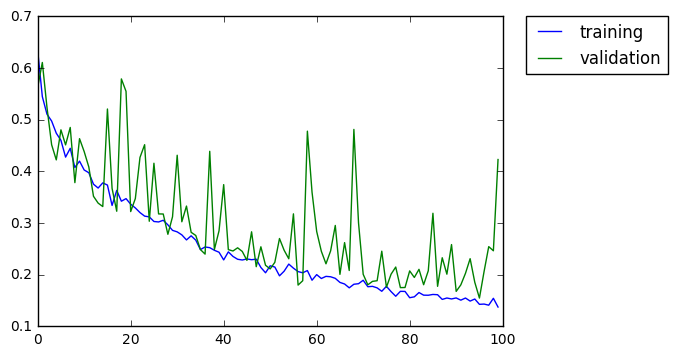

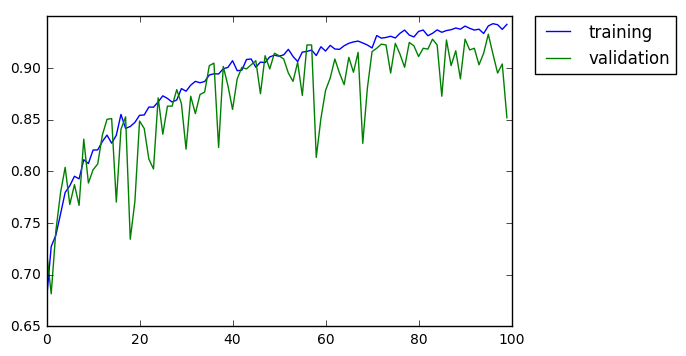

In [27]:
"""
Plot the learning training progress & acc
"""
train_loss = history_model.history.get('loss')
valid_loss = history_model.history.get('val_loss')

train_acc = history_model.history.get('acc')
valid_acc = history_model.history.get('val_acc')

plt.plot(np.arange(len(train_loss)), train_loss, label = "training")
plt.plot(np.arange(len(valid_loss)), valid_loss, label = "validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label = "training")
plt.plot(np.arange(len(valid_acc)), valid_acc, label = "validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

[[  1.56355679e-01   8.43644261e-01]
 [  9.99996901e-01   3.11059125e-06]
 [  8.48812461e-01   1.51187584e-01]
 [  1.50368444e-03   9.98496294e-01]
 [  6.79536819e-01   3.20463181e-01]]
[1 0 0 1 0]


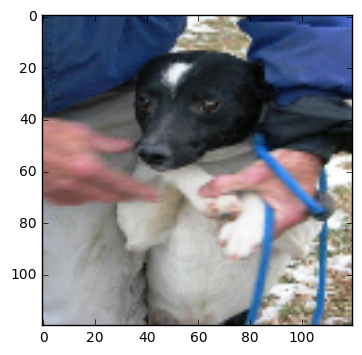

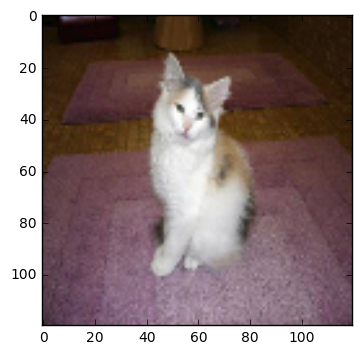

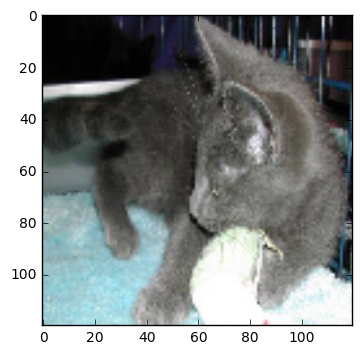

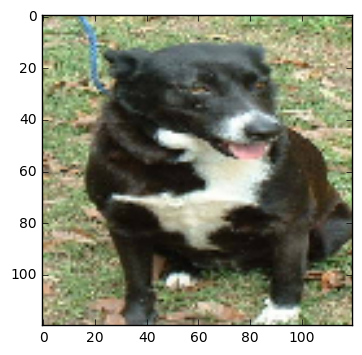

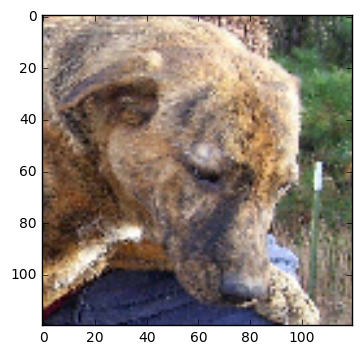

In [42]:
"""
BLOCK9
Test some results
"""
use_trained = True
if use_trained:
    model = load_model("cat_dog.h5")
else:
    pass

im_to_test = op_img(img_test_list[0:5], (im_w, im_h, im_c))
y_pred = model.predict(im_to_test)
binary_out = y_pred.argmax(axis=1)
print(y_pred)
print(binary_out)

for ix in im_to_test:
    plt.imshow(ix.astype('uint8'))
    plt.show()

[[  8.84664729e-02   9.11533535e-01]
 [  9.99902368e-01   9.76530937e-05]
 [  9.97299254e-01   2.70073046e-03]]
[1 0 0]


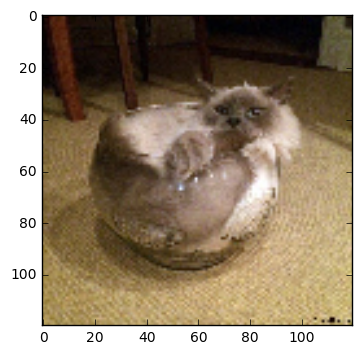

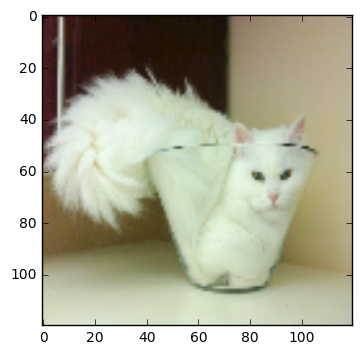

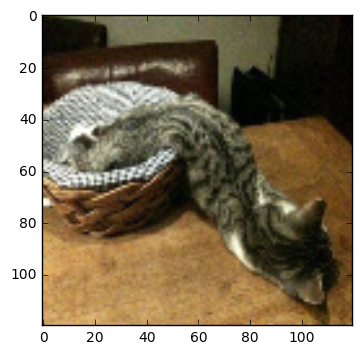

In [45]:
d_spec = "dataset/special_case/"
im_spec = glob.glob(d_spec + "*")
im_spec = op_img(im_spec, (im_w, im_h, im_c))
y_pred = model.predict(im_spec)
binary_out = y_pred.argmax(axis=1)
print(y_pred)
print(binary_out)

for ix in im_spec:
    plt.imshow(ix.astype('uint8'))
    plt.show()